In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
ROOT_PATH = Path().resolve().parent.parent
ROOT_DIR = str(ROOT_PATH)
if ROOT_DIR not in sys.path:
    sys.path.insert(1, ROOT_DIR)

In [3]:
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt
from utils import read_wav, write_wav
from constants import HEXADECAGONAL_TRACK_ORDER, HESUVI_TRACK_ORDER, SPEAKER_NAMES
from impulse_response import ImpulseResponse
from impulse_response_estimator import ImpulseResponseEstimator
from hrir import HRIR

## Read data

In [4]:
dir_path = ROOT_PATH.joinpath('data', 'demo')
estimator = ImpulseResponseEstimator.from_pickle(ROOT_PATH.joinpath('data', 'sweep-6.15s-48000Hz-32bit-2.93Hz-24000Hz.pkl'))
hrir = HRIR(estimator)
hrir.open_recording(dir_path.joinpath('FL,FR.wav'), ['FL', 'FR'])
ir = hrir.irs['FL']['left']
#ir.crop_head()
ir.data /= np.max(np.abs(ir.data))

## Lundeby method

In [9]:
t = np.arange(0, 1 / ir.fs * len(ir), 1 / ir.fs)
peak_time = ir.peak_index() / ir.fs

# 1. The squared impulse response is averaged into localtime intervals in the range of 10–50 ms,
# to yield asmooth curve without losing short decays.
squared = ir.data[ir.peak_index():] ** 2  # Square data
t_squared = np.arange(0, 1 / ir.fs * len(squared), 1 / ir.fs)
wd = 0.03  # Window duration
n = int(len(squared) / ir.fs / wd)  # Number of time windows
w = int(len(squared) / n)  # Width of a single time window
t_windows = np.arange(n) * wd + wd / 2
windows = squared.copy()
windows = np.reshape(windows[:n*w], (n, w))  # Split into time windows
windows = np.mean(windows, axis=1)  # Average each time window
windows = 10 * np.log10(windows)  # dB

# 2. A first estimate for the background noise level is deter-mined  from a time segment containing the last 10  %of the impulse response.
# This gives a reasonable statis-tical selection without a large systematic error, if thedecay continues to the end of the response.
tail = squared[int(-0.1 * len(squared)):]
noise_floor = np.mean(tail)
noise_floor = 10 * np.log10(noise_floor)
print(f'Noise floor: {noise_floor}')

# 3. The decay slope is estimated using linear regression between the time interval containing the response 0 dBpeak,
# and  the  first interval 5–10 dB above the  background noise level.
slope_end = np.argwhere(windows >= noise_floor + 10)[-1, 0]
slope, intercept, _, _, _ = stats.linregress(t_windows[:slope_end], windows[:slope_end])

# 4. A preliminary crosspoint is determined at the intersection of the decay slope and the background noise level.
crosspoint_time = (noise_floor - intercept) / slope
print(f'Crosspoint {crosspoint_time}')
crosspoint_index = np.argwhere(t_windows >= crosspoint_time)[0, 0]  # Index of first window which comes after slope end time

# 5. A new time interval length is calculated according tothe calculated slope, so that there are 3–10 intervalsper 10 dB of decay.
wd = 10 / (abs(slope) * 3)
n = int(len(squared) / ir.fs / wd)  # Number of time windows
w = int(len(squared) / n)  # Width of a single time window
t_windows = np.arange(n) * wd + wd / 2

# 6. The squared impulse is averaged into the new local timeintervals.
windows = squared.copy()
windows = np.reshape(windows[:n*w], (n, w))  # Split into time windows
windows = np.mean(windows, axis=1)  # Average each time window
windows = 10 * np.log10(windows)  # dB

# Steps 7–9 are iterated until the crosspoint is found to converge(max. 5 iterations).
for _ in range(5):
    # 7. The background noise level is determined again. The evaluated noise segment should start from a point
    # corresponding to 5–10 dB of decay after the crosspoint, or a minimum of 10 % of the total response length.
    crosspoint_index = np.argwhere(t_windows >= crosspoint_time)[0, 0]
    crosspoint_value = windows[crosspoint_index]
    noise_floor_start_index = np.argwhere(windows <= crosspoint_value - 5)[0, 0]  # Index to the first window which is 5 dB below crosspoint
    #noise_floor_start_time = max(t_windows[noise_floor_start_index], 0.1 * ir.duration())  # Discovered index or 10% of total IR length
    #noise_floor_start_time = t_windows[noise_floor_start_index]  # Discovered index or 10% of total IR length
    noise_floor_start_time = crosspoint_time * 1.33
    #noise_floor_end_time = noise_floor_start_time + 0.1 * len(squared) / ir.fs  # TODO: Until the very end?
    noise_floor_end_time = noise_floor_start_time + crosspoint_time
    noise_floor = np.mean(squared[np.logical_and(t_squared >= noise_floor_start_time, t_squared <= noise_floor_end_time)])
    noise_floor = 10 * np.log10(noise_floor)
    print(f'Noise floor ({noise_floor_start_time * 1000:.0f} ms -> {noise_floor_end_time * 1000:.0f} ms): {noise_floor}')
    
    # 8. The late decay slope is estimated for a dynamic range of 10–20 dB, starting from a point 5–10 dB above the noise level.
    slope_end = np.argwhere(windows >= noise_floor + 8)[-1, 0]
    slope_start = np.argwhere(windows >= noise_floor + 28)[-1, 0]
    late_slope, late_intercept, _, _, _ = stats.linregress(t_windows[slope_start:slope_end], windows[slope_start:slope_end])
    print(f'{slope_start} -> {slope_end}: {late_slope:.1f}t + {late_intercept:.2f}')
    
    # 9. A new crosspoint is found.
    crosspoint_time = (noise_floor - late_intercept) / late_slope
    print(f'Crosspoint {crosspoint_time}')
    new_crosspoint_index = np.argwhere(t_windows >= crosspoint_time)[0, 0]  # Index of first window which comes after slope end time
    if new_crosspoint_index == crosspoint_index:
        # Converged
        break

#return windows, noise_floor

Noise floor: -103.3426525206416
Crosspoint 0.4646972781730738
Noise floor (618 ms -> 1083 ms): -96.64195229876123
10 -> 18: -134.0t + -37.29
Crosspoint 0.44298930086643074
Noise floor (589 ms -> 1032 ms): -96.47679776457109
10 -> 18: -134.0t + -37.29
Crosspoint 0.44175666238795824


## Chu's method

In [29]:
# Subtracting noise floor from the squared impulse response
# https://nrc-publications.canada.ca/eng/view/ft/?id=35a62e95-3db6-4704-abed-b9cd6a2ce11e
print(10 ** (noise_floor / 10))
chu = squared - 10 ** (noise_floor / 10)
chu[chu <= 0] = 1e-18
chu = 10 * np.log10(chu)
chu = np.reshape(chu[:n*w], (n, w))
chu = np.mean(chu, axis=1)

2.2507135396842507e-10


## Lundeby plots

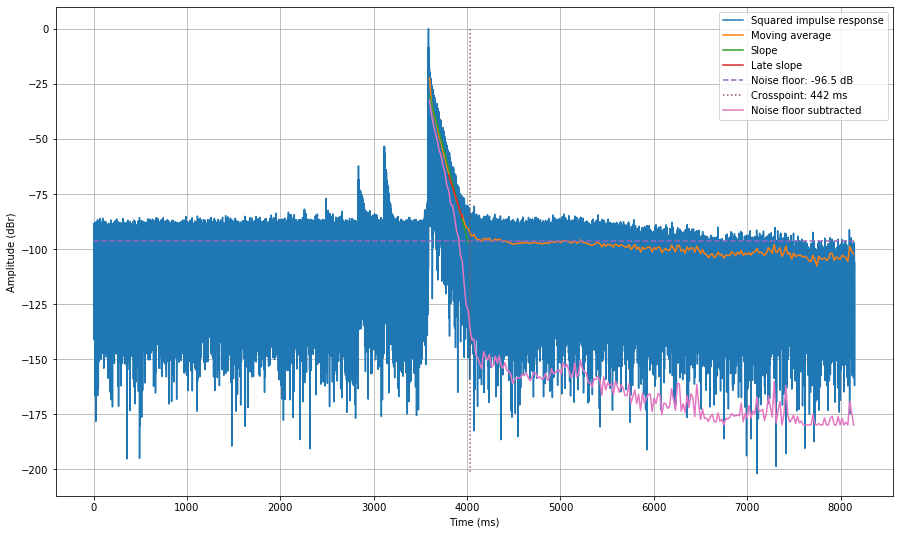

In [11]:
tw = t_windows + peak_time
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
ax.plot(t * 1000, 10 * np.log10(ir.data ** 2), label='Squared impulse response')
ax.plot(tw * 1000, windows, label='Moving average')
ax.plot(tw[:crosspoint_index] * 1000, t_windows[:crosspoint_index] * slope + intercept, label='Slope')
ax.plot(tw[slope_start:slope_end] * 1000, t_windows[slope_start:slope_end] * late_slope + late_intercept, label='Late slope')
ax.plot([0, tw[-1] * 1000], [noise_floor, noise_floor], linestyle='--', label=f'Noise floor: {noise_floor:.1f} dB')
ax.plot(
    (np.array([crosspoint_time, crosspoint_time]) + peak_time) * 1000,
    [0, np.min(10 * np.log10(squared))],
    linestyle='dotted', label=f'Crosspoint: {crosspoint_time * 1000:.0f} ms'
)
ax.plot(tw * 1000, chu, label='Noise floor subtracted')
ax.grid()
ax.legend(loc='upper right')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (dBr)')
plt.show()

## Decay parameters

In [13]:
td = int(crosspoint_time * ir.fs)
t_td = t[:td]
_ir = ir.copy()
_ir.crop_head()
hilbert = np.imag(signal.hilbert(_ir.data))
schroeder = np.cumsum(hilbert[td::-1]**2 / np.sum(hilbert[:td]**2))[:0:-1]
schroeder = 10 * np.log10(schroeder)

# Early decay time
start_edt = np.argwhere(schroeder <= -1)[0, 0]
end_edt = np.argwhere(schroeder <= -10)[0, 0]
slope_edt, intercept_edt, _, _, _ = stats.linregress(t_td[0:end_edt], schroeder[0:end_edt])
line_edt = slope_edt * t_td + intercept_edt
edt = -10 / slope_edt
print(f'EDT: {edt*1000:.0f} ms, slope: {slope_edt:.1f} dB/s')

# RT20
start = np.argwhere(schroeder <= -5)[0, 0]  # Find index of -5 dB
end20 = np.argwhere(schroeder <= -25)[0, 0]
slope20, intercept20, _, _, _ = stats.linregress(t_td[start:end20], schroeder[start:end20])
line20 = slope20 * t_td + intercept20
rt20 = -20 / slope20
print(f'RT20: {rt20*1000:.0f} ms, slope: {slope20:.1f} dB/s')

# RT30
end30 = np.argwhere(schroeder <= -35)[0, 0]
slope30, intercept30, _, _, _ = stats.linregress(t_td[start:end30], schroeder[start:end30])
line30 = slope30 * t_td + intercept30
rt30 = -30 / slope30
print(f'RT30: {rt30*1000:.0f} ms, slope: {slope30:.1f} dB/s')

# RT60
end60 = np.argwhere(schroeder <= -65)[0, 0]
slope60, intercept60, _, _, _ = stats.linregress(t_td[start:end60], schroeder[start:end60])
line60 = slope60 * t_td + intercept60
rt60 = -60 / slope60
print(f'RT60: {rt60*1000:.0f} ms, slope: {slope60:.1f} dB/s')

EDT: 27 ms, slope: -370.0 dB/s
RT20: 108 ms, slope: -184.6 dB/s
RT30: 170 ms, slope: -176.6 dB/s
RT60: 396 ms, slope: -151.6 dB/s


## Decay slopes

In [14]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [19]:
avg = running_mean(squared, w)
avg = 10 * np.log10(avg)

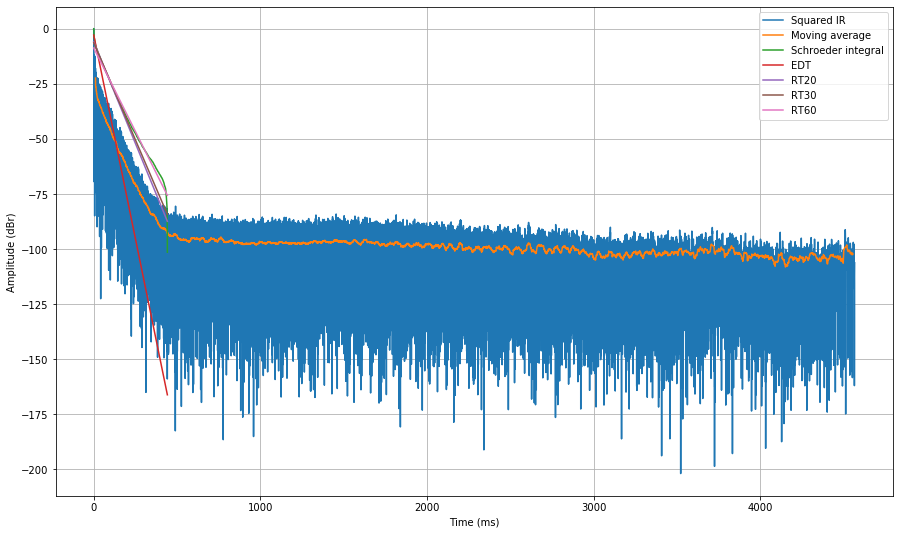

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
ax.plot(t_squared * 1000, 10 * np.log10(squared), label='Squared IR')
ax.plot(t_squared[w // 2:-(w // 2 - 1)] * 1000, avg, label='Moving average')
ax.plot(t[:td] * 1000, schroeder, label='Schroeder integral')
ax.plot(t_td * 1000, line_edt, label='EDT')
ax.plot(t_td * 1000, slope20 * t_td + intercept20, label='RT20')
ax.plot(t_td * 1000, slope30 * t_td + intercept30, label='RT30')
ax.plot(t_td * 1000, slope60 * t_td + intercept60, label='RT60')
ax.grid()
ax.legend(loc='upper right')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (dBr)')
plt.show()

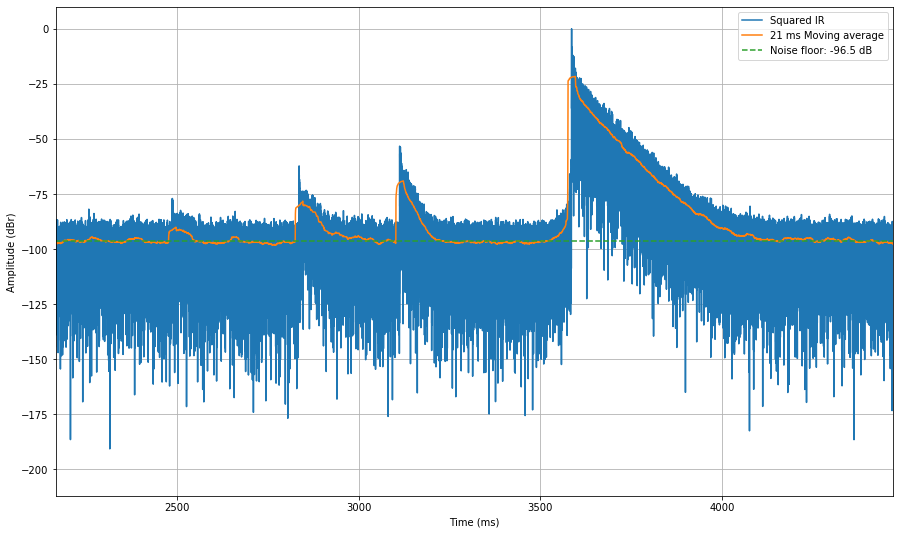

In [23]:
sq2 = ir.data ** 2
avg2 = running_mean(sq2, w)
sq2 = 10 * np.log10(sq2)
avg2 = 10 * np.log10(avg2)
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
ax.plot(t * 1000, sq2, label='Squared IR')
ax.plot(t[w // 2:-(w // 2 - 1)] * 1000, avg2, label=f'{wd*1000:.0f} ms Moving average')
ax.plot([0, tw[-1] * 1000], [noise_floor, noise_floor], linestyle='--', label=f'Noise floor: {noise_floor:.1f} dB')
ax.grid()
ax.legend(loc='upper right')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (dBr)')
ax.set_xlim([
    (peak_time - 3 * estimator.duration / estimator.n_octaves) * 1000,  # 3 octaves before peak
    #ir.duration() * 1000
    (peak_time + 2 * crosspoint_time) * 1000
])
plt.show()

In [24]:
print(f'Noise floor: {noise_floor:.2f} dB')
print(f'Moving average median: {np.median(windows[crosspoint_index:crosspoint_index + 20])} dB')
print(f'Last window: {windows[-1]}')

Noise floor: -96.48 dB
Moving average median: -95.66491841524743 dB
Last window: -102.31185686194058


3.585770833333333


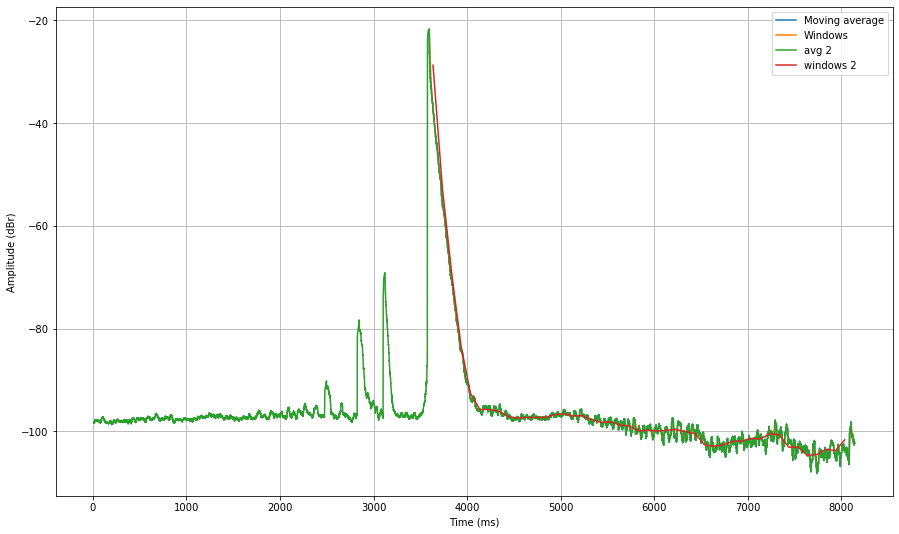

In [27]:
tw = t_windows + peak_time
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
ax.plot((t_squared[w // 2:-(w // 2 - 1)] + peak_time) * 1000, avg, label='Moving average')
ax.plot(tw * 1000, windows, label='Windows')
ax.plot(t[w // 2:-(w // 2 - 1)] * 1000, avg2, label=f'avg 2')


_wd = 0.1
_n = int(len(squared) / ir.fs / _wd)  # Number of time windows
_w = int(len(squared) / _n)  # Width of a single time window
_t_windows = np.arange(_n) * _wd + _wd / 2
_windows = squared.copy()
_windows = np.reshape(_windows[:_n*_w], (_n, _w))  # Split into time windows
_windows = np.mean(_windows, axis=1)  # Average each time window
_windows = 10 * np.log10(_windows)


print(peak_time)
ax.plot((_t_windows + peak_time) * 1000, _windows, label='windows 2')

ax.grid()
ax.legend(loc='upper right')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (dBr)')
#ax.set_xlim([
#    (peak_time - 1 * estimator.duration / estimator.n_octaves) * 1000,  # 3 octaves before peak
#    #ir.duration() * 1000
#    (peak_time + 2 * crosspoint_time) * 1000
#])
plt.show()

In [28]:
x = np.array([1e-9, 1e-10, 1e-11])
X = 10 * np.log10(x)
print(x, np.mean(x))
print(X, np.mean(X))
print(10 * np.log10(np.mean(x)))
print(np.mean(10 * np.log10(x)))

[1.e-09 1.e-10 1.e-11] 3.7e-10
[ -90. -100. -110.] -100.0
-94.31798275933005
-100.0
